In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
os.listdir('data')

['savingacct_txn.csv',
 'creditcard_txn.csv',
 '.DS_Store',
 'cust_past1year_snapshot.xlsx',
 'cust.csv',
 'currentacct_txn.csv',
 'cust_dna.csv',
 'model',
 'cust_prev.csv']

In [4]:
df_cur = pd.read_csv('data/cust.csv')
df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
df_prev = pd.read_csv('data/cust_prev.csv')

df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

df_comb['is_affluent_prev'] = (df_comb['BE_SEGMENT_prev'] <= 2).astype(int)
df_comb['is_affluent_cur'] = (df_comb['BE_SEGMENT_cur'] <= 2).astype(int)
df_comb = df_comb[df_comb['is_affluent_prev'] == 0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df_comb.groupby(['is_affluent_cur']).count()[['id']]

,id
is_affluent_cur,
0,5740
1,257


In [7]:
df_reg = df_comb[['id', 'is_affluent_cur']]

train = pd.read_csv('data/model/train.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
val = pd.read_csv('data/model/validate.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
test = pd.read_csv('data/model/test.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
val_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in val['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

# Transactions 

<AxesSubplot:>

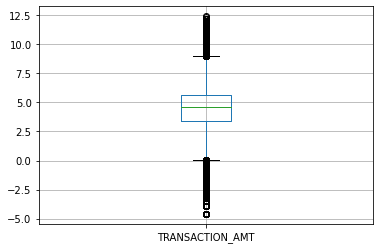

In [18]:
df_saving = pd.read_csv('data/creditcard_txn.csv')
df_saving['TRANSACTION_DATE'] = pd.to_datetime(df_saving['TRANSACTION_DATE'])
df_saving['D_TRAN_AMOUNT_log'] = np.log(df_saving['TRANSACTION_AMT'].replace({0: 1}))

np.log(df_saving[['TRANSACTION_AMT']]).boxplot()

### Feature extraction

In [19]:
def get_features(df, bins):

    rolling_window = 10    

    df.loc[:, 'mult'] = df['D_TRAN_TYPE'].replace({'D': 1, 'C': -1})
    df.loc[:, 'transact'] = df['mult'] * df['D_TRAN_AMOUNT_log']
    df = df[['transact', 'D_TRANSACTION_DATE', 'id']]

    tmp = pd.date_range(start='1/1/2021', end='31/12/2021')
    tmp = pd.DataFrame({'transact': 0, 'D_TRANSACTION_DATE': tmp})
    df = df.append(tmp).sort_values('D_TRANSACTION_DATE')
    df.loc[:, 'D_TRANSACTION_DATE'] = (df['D_TRANSACTION_DATE'] \
                                .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000
    df = df.groupby('D_TRANSACTION_DATE').sum().reset_index()
    df.loc[:, 'day'] = df['D_TRANSACTION_DATE'].astype(int)
    del df['D_TRANSACTION_DATE']
    
    df_rolled = df.rolling(window=rolling_window).apply(lambda x : sum(x) / window)
    df_rolled = df_rolled[~df_rolled['transact'].isna()][['transact']]
    
    tmp = np.digitize(df_rolled['transact'], bins)
    res = pd.DataFrame(tmp).reset_index(drop=False).groupby(0).count()['index']
    
    return res

In [20]:
window = 10

bin_size = 0.25
bin_min, bin_max = -5, 7
bins = [bin_min + i * bin_size for i in range(int((bin_max - bin_min) / bin_size) + 1)]

X = np.zeros((len(df_reg['id']), len(bins)))

for i, cid in tqdm(enumerate(df_reg['id'])):
    df = df_saving[df_saving['id'] == cid]
    if len(df) > 0:
        tmp = get_features(df, bins)
        X[i, tmp.index - 1] = tmp

0it [00:00, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


KeyError: "['D_TRANSACTION_DATE'] not in index"

In [16]:
X.sum(axis=0)

NameError: name 'X' is not defined

In [138]:
X.shape

(5997, 33)

### Modelling (SVM)

In [133]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_fscore_support, plot_roc_curve

y = df_reg['is_affluent_cur']

X_train = X[train_idxs, :]
y_train = np.array(y)[train_idxs]
X_val = X[val_idxs, :]
y_val = np.array(y)[val_idxs]
X_test = X[test_idxs, :]
y_test = np.array(y)[test_idxs]

In [134]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [135]:
pred_probs = svm.predict_proba(X_val)
pred = (pred_probs[:, 0] < 0.955).astype(int)

In [136]:
precision, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
precision, recall, f1

(0.9266399631630284, 0.5333333333333333, 0.6597448057087336)

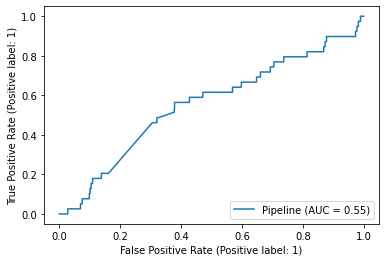

In [137]:
# confusion_matrix(pred, y_val)
plot_roc_curve(svm, X_val, y_val)

In [128]:
X1 = X